In [26]:
import pandas as pd
import numpy as np
import os
import random
import PIL
from google.colab import drive
from PIL import Image, ImageOps
from tqdm import tqdm
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GaussianNoise
from keras.layers import Conv2D, MaxPool2D, Input, concatenate, Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras import regularizers, optimizers
import keras
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, InceptionV3
from sklearn.model_selection import train_test_split
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

seed = random.randint(1, 100)

In [27]:
drive.mount('/content/drive')

IMG_SIZE = 256

if IMG_SIZE == 256:
    path = '/content/drive/My Drive/parcel_boundaries_dataset/patched_data/256'
elif IMG_SIZE == 512:
    path = '/content/drive/My Drive/parcel_boundaries_dataset/patched_data/512'

input_path = os.path.join(path,"image")
mask_path = os.path.join(path,"binary_mask")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
image_input_path = sorted([ os.path.join(input_path, fname) for fname in os.listdir(input_path) if fname.endswith(".png") ])

image_mask_path = sorted([ os.path.join(mask_path, fname) for fname in os.listdir(mask_path) if fname.endswith(".png")])

path_df = pd.DataFrame({'image':image_input_path,'mask':image_mask_path})

In [29]:
train, val = train_test_split(path_df,test_size=0.15, random_state=seed)



In [30]:
#https://www.kaggle.com/code/iasonasxrist/mri-brain-tumour-segmentation-with-unet-cnn/notebook

EPOCHS = 20
BATCH_SIZE = 8
ImgHeight = IMG_SIZE
ImgWidth = IMG_SIZE
Channels = 3

data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True)

imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)

timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image",
                                            batch_size= BATCH_SIZE,
                                            seed=seed,

                                            class_mode=None,
                                            color_mode='rgb')

tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask",
                                            batch_size=BATCH_SIZE,
                                            seed=seed,
                                            class_mode=None,
                                            color_mode='grayscale')

imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)

vimage_generator = imagegen.flow_from_dataframe(dataframe=val,
                                             x_col = "image",
                                             batch_size = BATCH_SIZE,
                                             seed=seed,
                                             class_mode=None,
                                             color_mode='rgb')
# validation data generator
vmask_generator = maskgen.flow_from_dataframe(dataframe=val,
                                             x_col = "mask",
                                             batch_size = BATCH_SIZE,
                                             seed=seed,
                                             class_mode=None,
                                             color_mode='grayscale')


def data_iterator(image_gen,mask_gen):
    for img, mask in zip(image_gen,mask_gen):
        yield img, mask

train_gen = data_iterator(timage_generator, tmask_generator)
val_gen = data_iterator(vimage_generator,vmask_generator)

Found 3304 validated image filenames.
Found 3304 validated image filenames.
Found 584 validated image filenames.
Found 584 validated image filenames.


In [31]:
for _ in range(5):
    img = vmask_generator.next()
    print(img.shape)
    print(np.unique(img))

(8, 256, 256, 1)
[0. 1.]
(8, 256, 256, 1)
[0. 1.]
(8, 256, 256, 1)
[0. 1.]
(8, 256, 256, 1)
[0. 1.]
(8, 256, 256, 1)
[0. 1.]


In [32]:
def convolutional_layer_block(previous_layer, filter_size, kernel):
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(previous_layer)
        x = Dropout(0.2)(x)
        x = Conv2D(filter_size, kernel, activation='relu', kernel_initializer='he_normal', padding='same')(x)
        return x

def u_net(img_shape, n_classes):
    inputs = Input(shape=img_shape)
    previous_layer = inputs

    concatenate_link = []
    for filter_size in [32, 64, 128, 256]:
        x = convolutional_layer_block(previous_layer, filter_size, (3,3))
        concatenate_link.append(x)
        x = MaxPooling2D((2, 2))(x)
        previous_layer = x

    concatenate_link = list(reversed(concatenate_link))
    x = convolutional_layer_block(previous_layer, 160, (3,3))
    previous_layer = x

    for count,filter_size in enumerate([256, 128, 64, 32]):
        x = Conv2DTranspose(filter_size, (2, 2), strides=(2, 2), padding='same')(previous_layer)
        x = concatenate([x, concatenate_link[count]], axis = 3)
        convolutional_layer_block(x, filter_size, (3,3))
        previous_layer = x

    if n_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, kernel_size=(1, 1), activation=activation)(previous_layer)

    return Model(inputs=inputs, outputs=outputs)

model = u_net((IMG_SIZE, IMG_SIZE, 3), n_classes = 1)

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_18 (Dropout)           (None, 256, 256, 32  0           ['conv2d_38[0][0]']              
                                )                                                           

In [34]:
model.compile(optimizer = Adam(), loss = "binary_crossentropy", metrics = ['accuracy'])

In [35]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(("/content/drive/MyDrive/"+'boundary_model_e10_bs32.h5'), verbose = 1, save_best_only=True, save_weights_only=True)]

In [36]:
train_step = timage_generator.n/BATCH_SIZE
val_step = vimage_generator.n/BATCH_SIZE

model.fit(train_gen, steps_per_epoch = train_step, epochs= EPOCHS, validation_data = val_gen, validation_steps = val_step, callbacks = callbacks)

Epoch 1/20
413/413 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.8273
Epoch 1: val_loss improved from inf to 0.45220, saving model to /content/drive/MyDrive/boundary_model_e10_bs32.h5
413/413 [==============================] - 93s 221ms/step - loss: 0.3836 - accuracy: 0.8273 - val_loss: 0.4522 - val_accuracy: 0.8553
Epoch 2/20
413/413 [==============================] - ETA: 0s - loss: 0.3437 - accuracy: 0.8302
Epoch 2: val_loss did not improve from 0.45220
413/413 [==============================] - 91s 220ms/step - loss: 0.3437 - accuracy: 0.8302 - val_loss: 0.4845 - val_accuracy: 0.8495
Epoch 3/20
413/413 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.8324
Epoch 3: val_loss did not improve from 0.45220
413/413 [==============================] - 90s 219ms/step - loss: 0.3296 - accuracy: 0.8324 - val_loss: 0.5178 - val_accuracy: 0.8481
Epoch 4/20
413/413 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.8333
Epoch 

Text(0.5, 1.0, 'Prediction')

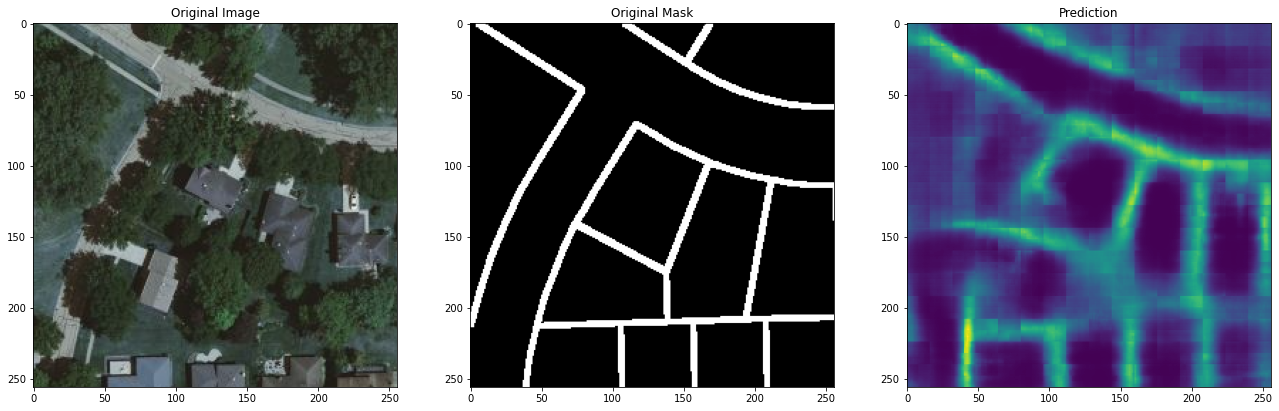

In [38]:
image = cv2.imread(r'/content/drive/My Drive/parcel_boundaries_dataset/patched_data/256/image/chicago_boundary_1_image_patch_1.png')
mask = cv2.imread(r'/content/drive/My Drive/parcel_boundaries_dataset/patched_data/256/binary_mask/chicago_boundary_1_mask_patch_1.png')
    
img = cv2.resize(image,(IMG_SIZE,IMG_SIZE))
img = img/255
img = img[np.newaxis,:,:,:]
pred=model.predict(img)[:,:,:]

    
plt.figure(figsize=(30,30))
plt.subplot(1,4,1)
plt.imshow(np.squeeze(img))
plt.title('Original Image')
plt.subplot(1,4,2)
plt.imshow(mask)
plt.title('Original Mask')
plt.subplot(1,4,3)
plt.imshow(np.squeeze(pred))
plt.title('Prediction')
    